In [1]:
#%matplotlib notebook
import time, winsound, h5py, os, copy
import numpy as np
import matplotlib.pyplot as plt
from lcls_beamline_toolbox.xraybeamline2d import beam1d as beam, optics1d as optics, beamline1d as beamline
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
from Functions import *
from LCLS_Optics import *

In [2]:
N = 256       # number of sampling points
E0 = 9.9e3    # photon energy in eV
z_off=.12     # distance offset between VCC crystal 1 and CC crystal 1
d23=.2        # distance between VCC crystal 2 and 3
f_lens = .085 # spectrometer lens focal distance
FOV = 2e-3   # [m]
alphaAsym = np.deg2rad(2)

tau = 20
window = 2000
FWHM = 50e-6

tilt_target = window/4
delta_a = np.arctan(tilt_target*1e-15 * 3e8)

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': FWHM*1.669/2,
    'sigma_y': FWHM*1.669/2,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 0
}

hbar = 0.6582
bw = 2 * np.sqrt(2) * hbar * np.sqrt(np.log(2)) / tau
print('bandwidth {}eV'.format(round(bw,2)))

bandwidth 0.08eV


In [3]:
def define_bl(E0=E0, FOV=FOV, N=N, delta_a=delta_a):
    hkl = [5,5,5]
    
    tilt1 = Force_tilt('tilt1', delta_a=delta_a, z=400-.02, orientation=0)
    im0 = optics.PPM('im0', z=400-.01, FOV=FOV, N=N)
    
    #crl1 = CRL_no_abs('crl1', z=400, E0=E0, f=85e-3, diameter=5e-3, orientation=1)
    
    #im1 = optics.PPM('im1', z=crl1.z+crl1.f, FOV=FOV, N=N)
    
    zC1 = 400.
    crystal1 = optics.Crystal('c1', hkl=hkl, length=10e-2, width=20e-3, z=zC1, E0=E0,
                              alphaAsym=0, orientation=2, pol='s', delta=0.e-6)
    
    z56 = np.cos(np.pi-2*crystal1.alpha)*.01
    im2 = optics.PPM('im2', z=crystal1.z-z56, FOV=FOV, N=N)
    
    #devices = [im0, crl1, im1, crystal1, im2]
    devices = [im0, crystal1, im2]
    return devices

devices = define_bl(E0=E0, FOV=FOV, N=N)
bl = beamline.Beamline(devices, ordered=True)

b 1.00
after c1: -3.0341


In [4]:
%%capture capt
beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, tau=tau, time_window=window)
#pulse.propagate(beamline=bl, screen_names=['im0','im1','im2'])
pulse.propagate(beamline=bl, screen_names=['im0','im2'])


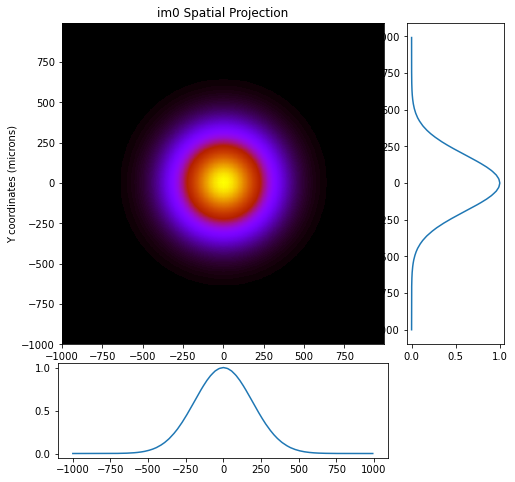

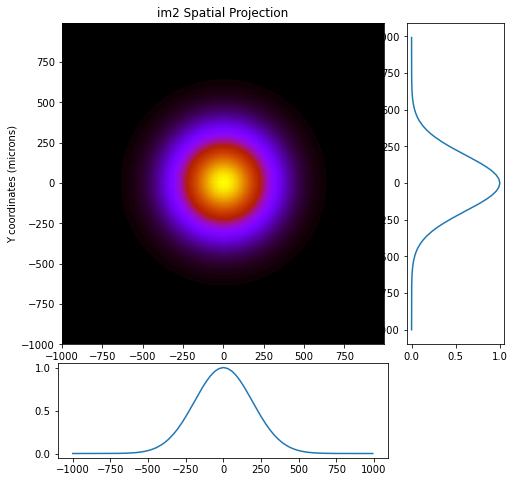

In [5]:
''' beam profiles '''
im_names = ['im0', 'im1', 'im2']
part_names = ['input', 'focus', 'reflected']
im_names = ['im0', 'im2']
part_names = ['input', 'reflected']

for i in range(len(im_names)):
    im_name = im_names[i]
    part_name = part_names[i]
    
    # spatial projection (xy)
    pulse.imshow_projection(im_name)


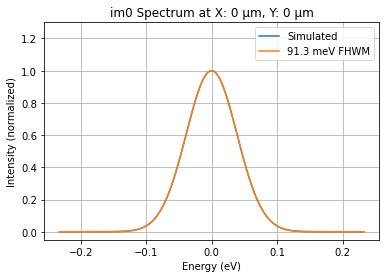

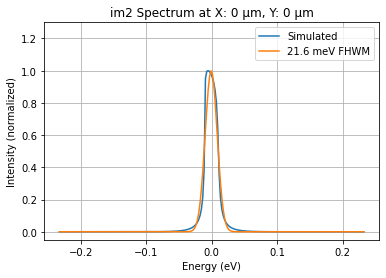

In [6]:
for i in range(len(im_names)):
    im_name = im_names[i]
    part_name = part_names[i]
    pulse.plot_spectrum(im_name)

Text(0.5, 0, 't (fs)')

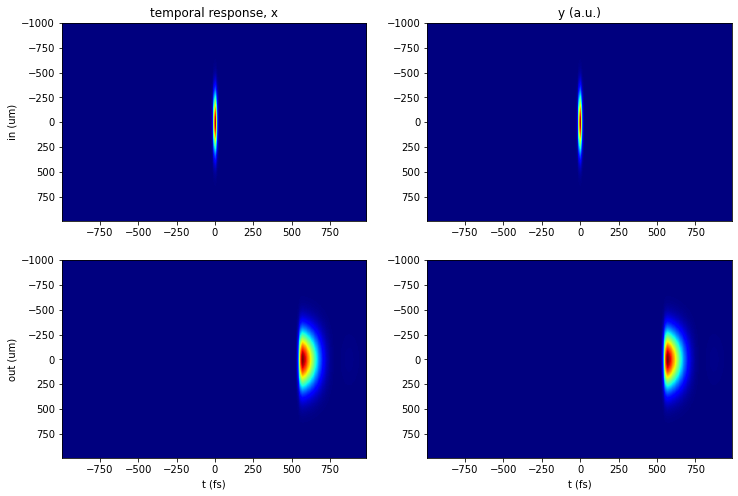

In [7]:
''' temporal profile '''

temporal_in = np.square(np.abs(pulse.time_stacks['im0']))
temporal_out = np.square(np.abs(pulse.time_stacks['im2']))

t = pulse.t_axis
plt.figure(figsize=(12,8))
# x
img_in = np.sum(temporal_in, axis=0)
img_out = np.sum(temporal_out, axis=0)
plt.subplot(2,2,1)
plt.imshow(img_in, cmap='jet',
           extent = [t.min(), t.max(), pulse.x['im0'].max()*1e6, pulse.x['im0'].min()*1e6])
plt.title('temporal response, x')
plt.ylabel('in (um)')
plt.axis('tight')

plt.subplot(2,2,3)
plt.imshow(img_out, cmap='jet',
           extent = [t.min(), t.max(), pulse.x['im0'].max()*1e6, pulse.x['im0'].min()*1e6])
plt.axis('tight')
plt.ylabel('out (um)')
plt.xlabel('t (fs)')

# y
img_in = np.sum(temporal_in, axis=1)
img_out = np.sum(temporal_out, axis=1)
plt.subplot(2,2,2)
plt.imshow(img_in, cmap='jet',
           extent = [t.min(), t.max(), pulse.y['im0'].max()*1e6, pulse.y['im0'].min()*1e6])
plt.title('y (a.u.)')
plt.axis('tight')

plt.subplot(2,2,4)
plt.imshow(img_out, cmap='jet',
           extent = [t.min(), t.max(), pulse.y['im0'].max()*1e6, pulse.y['im0'].min()*1e6])
plt.axis('tight')
plt.xlabel('t (fs)')

Text(0.5, 0, 'E (eV)')

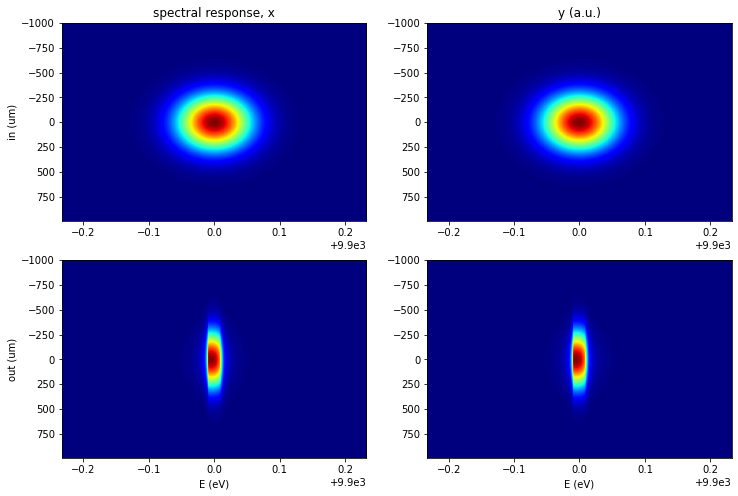

In [8]:
''' spectral profile '''
spectral_in = np.square(np.abs(pulse.energy_stacks['im0']))
spectral_out = np.square(np.abs(pulse.energy_stacks['im2']))

ev = pulse.energy
plt.figure(figsize=(12,8))
# x
img_in = np.sum(spectral_in, axis=0)
img_out = np.sum(spectral_out, axis=0)
plt.subplot(2,2,1)
plt.imshow(img_in, cmap='jet',
           extent = [ev.min(), ev.max(), pulse.x['im0'].max()*1e6, pulse.x['im0'].min()*1e6])
plt.title('spectral response, x')
plt.ylabel('in (um)')
plt.axis('tight')

plt.subplot(2,2,3)
plt.imshow(img_out, cmap='jet',
           extent = [ev.min(), ev.max(), pulse.x['im0'].max()*1e6, pulse.x['im0'].min()*1e6])
plt.axis('tight')
plt.ylabel('out (um)')
plt.xlabel('E (eV)')

# y
img_in = np.sum(spectral_in, axis=1)
img_out = np.sum(spectral_out, axis=1)
plt.subplot(2,2,2)
plt.imshow(img_in, cmap='jet',
           extent = [ev.min(), ev.max(), pulse.y['im0'].max()*1e6, pulse.y['im0'].min()*1e6])
plt.title('y (a.u.)')
plt.axis('tight')

plt.subplot(2,2,4)
plt.imshow(img_out, cmap='jet',
           extent = [ev.min(), ev.max(), pulse.y['im0'].max()*1e6, pulse.y['im0'].min()*1e6])
plt.axis('tight')
plt.xlabel('E (eV)')

In [9]:
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)
winsound.PlaySound("*", winsound.SND_ALIAS)